# Capstone Project - The Battle of the Neighborhoods (Week 1&2)
### Applied Data Science Capstone Course by IBM/Coursera 

### Table of contents
1. [Introduction](#introduction)
2. [Data](#data)
3. [Methodology](#methodology)
4. [Analysis](#analysis)
5. [Results](#results)
6. [Conclusion](#conclusion)

## 1. Introduction <a name="introduction"></a>

Berlin is the capital and largest city of Germany by both area and population. It hosts an exciting art and nightlife scene and, best of all, it is very affordable to live in. While looking for a place to fill your stomach, you can get easily lost in the decision of which place suits you best. This project aims to explore and analyze food venues surrounding the metro stations in Berlin and describe different clusters.

The Berlin-all-inclusive public transport system consists of U-Bahn (underground railway), S-Bahn (elevated railway), buses, and trams, which are managed by The Berliner Verkehrsbetriebe (BVG) and the Deutsche Bahn (DB). In the scope of this work I focused on **exploring and clustering food venues surrounding the U-Bahn with 173 stations**.

The results can be useful for those like going out to eat via the U-Bahn in Berlin. They provide the idea of what types of food surrounding each station.

## 2. Data <a name="data"></a>

Following data sources were used to extract and generate the required information:
* list of the Berlin U-Bahn stations (173 stations, total route length: 151,7 km) and their geographical coordinates web scraped from 
[Wikipedia: Liste der Berliner U-Bahnhöfe](https://de.wikipedia.org/wiki/Liste_der_Berliner_U-Bahnh%C3%B6fe).
* Foursquare Venue Data from Category Food and its Sub-categories.

#### Let's first install (if needed) and import necessary libraries:

In [1]:
import pandas as pd
import numpy as np

#!pip3 install beautifulsoup4
#!pip3 install lxml
#!pip3 install requests
from bs4 import BeautifulSoup
import requests

#!pip3 install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!pip3 install matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#!pip3 install folium
import folium # map rendering library

import json # library to handle JSON files

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize
#import xml.etree.ElementTree as et 

print("All requested libraries were successfully imported!")

All requested libraries were successfully imported!


#### Let's scrape data from the Wikipedia page and get a list of U-Bahn stations in Berlin and their coordinate values:

In [2]:
import urllib.request
    
url_ubahn = 'https://de.wikipedia.org/wiki/Liste_der_Berliner_U-Bahnh%C3%B6fe'
r_ubahn = requests.get(url_ubahn)
soup_ubahn = BeautifulSoup(r_ubahn.content,'lxml')

tables_ubahn = soup_ubahn.select('table')[1] # Select the second table counting from top
output_ubahn = []

# Create a loop to find all rows with class = '' to filter out rows that have pink or green background
# which are stations either being out of service or not yet put into operation
for row in tables_ubahn.find_all('tr', class_=''):
    
    # Retrieve all rows from only the first column which is relevant for the analysis
    items = row.find_all('td')[:1]
    if items:
        row = [i.text.strip() for i in items]
        output_ubahn.append(row)
        
# Transform the retrieved data to a pandas DataFrame      
df_ubahn = pd.DataFrame(output_ubahn, columns=['Station'])
df_ubahn.head()

,Station
0,"Adenauerplatz (Ad)52° 29′ 59″ N, 13° 18′ 26″ O"
1,"Afrikanische Straße (Afr)52° 33′ 38″ N, 13° 20..."
2,"Alexanderplatz (A)52° 31′ 17″ N, 13° 24′ 48″ O"
3,"Alexanderplatz (Al)52° 31′ 17″ N, 13° 24′ 48″ O"
4,"Alexanderplatz (Ap)52° 31′ 17″ N, 13° 24′ 48″ O"


#### The dataframe looks not so nice. Let's clean it!

In [3]:
# Remove parentheses and all the data within them since they're not necessary
df_ubahn = df_ubahn["Station"].str.replace(r"\(.*\)","")

# Remove duplicate stations since one station can have multiple lines going through
df_ubahn.drop_duplicates(keep = 'first', inplace=True)

# Reset index
df_ubahn = df_ubahn.to_frame().reset_index(drop=True)

# Spliting the dataframe into 3 new columns: Station, Latitude, Longitude
df_ubahn = df_ubahn.Station.str.extract(r'(?P<Station>.*?)(?P<Latitude>\d+°[^,]+),(?P<Longitude>.*)', expand=True)

df_ubahn.head()

,Station,Latitude,Longitude
0,Adenauerplatz,52° 29′ 59″ N,13° 18′ 26″ O
1,Afrikanische Straße,52° 33′ 38″ N,13° 20′ 3″ O
2,Alexanderplatz,52° 31′ 17″ N,13° 24′ 48″ O
3,Altstadt Spandau,52° 32′ 21″ N,13° 12′ 20″ O
4,Alt-Mariendorf,52° 26′ 23″ N,13° 23′ 15″ O


#### Let's convert the coordinates from degrees/minutes/seconds to decimal  for later mapping:

In [4]:
import re

def dms2dd(s):
    degrees, minutes, seconds, direction = re.split('[°\′″]+', s)
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction in ('S','W'):
        dd*= -1
    return dd

df_ubahn['Latitude'] = df_ubahn['Latitude'].apply(dms2dd)
df_ubahn['Longitude'] = df_ubahn['Longitude'].apply(dms2dd)

df_ubahn.head()

,Station,Latitude,Longitude
0,Adenauerplatz,52.499722,13.307222
1,Afrikanische Straße,52.560556,13.334167
2,Alexanderplatz,52.521389,13.413333
3,Altstadt Spandau,52.539167,13.205556
4,Alt-Mariendorf,52.439722,13.387500


#### Now the dataframe looks better. Let's check the size of it:

In [5]:
df_ubahn.shape

(173, 3)

#### Export the dataframe to a csv file:

In [6]:
df_ubahn.to_csv("df_ubahn.csv")

## 3. Methodology <a name="methodology"></a>

#### Let's first start finding coordinates for Berlin by using geopy library  and show the map

In [7]:
# Get the coordinate values of Berlin
address = 'Berlin, Germany'

geolocator = Nominatim(user_agent='berlin_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geographical coordinates of Berlin are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Berlin are 52.5170365, 13.3888599.


In [8]:
# Create a map of Berlin using extracted coordinates
map_berlin_ubahn = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add markers to map
for lat, lng, station in zip(
        df_ubahn['Latitude'],
        df_ubahn['Longitude'],
        df_ubahn['Station']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='',
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin_ubahn)
    
# Show map
map_berlin_ubahn

#### Let's define Foursquare credentials and version:

In [9]:
CLIENT_ID = '' # my Foursquare ID (removed on public repository)
CLIENT_SECRET = '' # my Foursquare Secret (removed on public repository)
VERSION = '20190718' # Foursquare API version

#### Let's explore the first U-Bahn station in the dataframe

In [10]:
# Get the first U-Bahn station's name
first_ubahn = df_ubahn.loc[0, 'Station']

# Get its latitude and longitude values
first_ubahn_latitude = df_ubahn.loc[0, 'Latitude']
first_ubahn_longitude = df_ubahn.loc[0, 'Longitude']

print("The first U-Bahn station's name is {}. Its coordinates are {}, {}".format(first_ubahn,
                                                                              first_ubahn_latitude,
                                                                              first_ubahn_longitude))

The first U-Bahn station's name is Adenauerplatz . Its coordinates are 52.499722222222225, 13.307222222222222


#### Let's fetch Foursquare Venue Category Hierarchy

In [11]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# Make the GET request
results = requests.get(categories_url).json()
len(results['response']['categories'])

categories_list = []

# Let's print only the top-level categories and their IDs and also add them to categories_list
def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


#### As we can see, the categoryId for food venues is 4d4b7105d754a06374d81259. Let's get top 50 food venues surrounding U-Bahn station Adenauerplatz withtin a radius of 500 meters:

*Funfact: The station was named after Konrad Adenauer, a German statesman who served as the first Chancellor of the Federal Republic of Germany (West Germany) from 1949 to 1963.*

In [12]:
LIMIT = 50
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    first_ubahn_latitude,
    first_ubahn_longitude,
    radius,
    LIMIT,
    "4d4b7105d754a06374d81259") # CategoryId of Food venue

results = requests.get(url).json() # Get the result to a json file

# Function that extracts the category of the venue:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [13]:
# Clean the json and structure it into a pandas dataframe:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) #flatten JSON

# Filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# Filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# Clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

/Users/minhmai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Bellucci,Italian Restaurant,52.499430,13.306800
1,Frau Behrens Torten,Café,52.501653,13.307663
2,SAVU,Modern European Restaurant,52.499323,13.305033
3,Block House,Steakhouse,52.499846,13.306933
4,Kurpfalz Weinstuben,German Restaurant,52.500898,13.307718


#### Let's create a function to repeat the same process to all the U-Bahn stations in Berlin

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):   
    venues_list = []
    for name, lat, lng, in zip(names, latitudes, longitudes):
        print(name)
        
        # Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT,
            "4d4b7105d754a06374d81259")
        
        # Make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # Return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_values = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_values.columns = ['Station',
                             'U-Bahn Latitude',
                             'U-Bahn Longitude',
                             'Venue',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue Category']
    return(nearby_values)

#### Write the code to run the above function on each U-Bahn station and create a new dataframe called food_ubahn.

In [15]:
food_ubahn = getNearbyVenues(names=df_ubahn['Station'],
                             latitudes=df_ubahn['Latitude'],
                             longitudes=df_ubahn['Longitude']
                            )

Adenauerplatz 
Afrikanische Straße 
Alexanderplatz 
Altstadt Spandau 
Alt-Mariendorf 
Alt-Tegel 
Alt-Tempelhof 
Amrumer Straße 
Augsburger Straße 
Bayerischer Platz 
Berliner Straße 
Bernauer Straße 
Biesdorf-Süd 
Birkenstraße 
Bismarckstraße 
Blaschkoallee 
Blissestraße 
Boddinstraße 
Borsigwerke 
Brandenburger Tor 
Breitenbachplatz 
Britz-Süd 
Bülowstraße 
Bundesplatz 
Bundestag 
Cottbusser Platz 
Dahlem-Dorf 
Deutsche Oper 
Eberswalder Straße 
Eisenacher Straße 
Elsterwerdaer Platz 
Ernst-Reuter-Platz 
Fehrbelliner Platz 
Frankfurter Allee 
Frankfurter Tor 
Franz-Neumann-Platz 
Französische Straße 
Freie Universität 
Friedrichsfelde 
Friedrichstraße 
Friedrich-Wilhelm-Platz 
Gesundbrunnen 
Gleisdreieck 
Gneisenaustraße 
Görlitzer Bahnhof 
Grenzallee 
Güntzelstraße 
Halemweg 
Hallesches Tor 
Hansaplatz 
Haselhorst 
Hauptbahnhof 
Hausvogteiplatz 
Heidelberger Platz 
Heinrich-Heine-Straße 
Hellersdorf 
Hermannplatz 
Hermannstraße 
Hohenzollernplatz 
Holzhauser Straße 
Hönow 
Innsbrucke

#### Let's check the size of the resulting dataframe:

In [16]:
print(food_ubahn.shape)
food_ubahn.head()

(4630, 7)


,Station,U-Bahn Latitude,U-Bahn Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adenauerplatz,52.499722,13.307222,Bellucci,52.499430,13.306800,Italian Restaurant
1,Adenauerplatz,52.499722,13.307222,Frau Behrens Torten,52.501653,13.307663,Café
2,Adenauerplatz,52.499722,13.307222,SAVU,52.499323,13.305033,Modern European Restaurant
3,Adenauerplatz,52.499722,13.307222,Block House,52.499846,13.306933,Steakhouse
4,Adenauerplatz,52.499722,13.307222,Kurpfalz Weinstuben,52.500898,13.307718,German Restaurant


#### Let's find out how many unique categories can be curated from all the returned venues:

In [17]:
print('There are {} uniques categories.'.format(len(food_ubahn['Venue Category'].unique())))
food_ubahn.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 122 uniques categories.


Venue Category
Café                               558
Bakery                             404
Italian Restaurant                 387
German Restaurant                  240
Vietnamese Restaurant              205
                                  ... 
Southern / Soul Food Restaurant      1
Souvlaki Shop                        1
Taiwanese Restaurant                 1
Turkish Home Cooking Restaurant      1
Afghan Restaurant                    1
Name: Venue Category, Length: 122, dtype: int64

#### Let's list all the unique categories

In [18]:
unique_categories = food_ubahn['Venue Category'].unique().tolist()
print('\n'.join(str(x) for x in unique_categories))

Italian Restaurant
Café
Modern European Restaurant
Steakhouse
German Restaurant
Bakery
Bagel Shop
Japanese Restaurant
Cantonese Restaurant
Sushi Restaurant
Sandwich Place
Vietnamese Restaurant
Mediterranean Restaurant
Asian Restaurant
Chinese Restaurant
Korean Restaurant
Restaurant
Vegetarian / Vegan Restaurant
Caucasian Restaurant
Fried Chicken Joint
Wings Joint
Austrian Restaurant
Greek Restaurant
American Restaurant
Bistro
Snack Place
Falafel Restaurant
Soup Place
Eastern European Restaurant
Doner Restaurant
French Restaurant
Indian Restaurant
Seafood Restaurant
Argentinian Restaurant
Brasserie
Burger Joint
Burrito Place
Spanish Restaurant
Breakfast Spot
Trattoria/Osteria
Salad Place
Tapas Restaurant
Bavarian Restaurant
Gastropub
Thai Restaurant
Buffet
Donut Shop
Currywurst Joint
BBQ Joint
Diner
Fast Food Restaurant
Pizza Place
Food Court
Turkish Restaurant
Middle Eastern Restaurant
Mexican Restaurant
Creperie
New American Restaurant
Persian Restaurant
Israeli Restaurant
Kebab Resta

#### As we can observe from the list, there are not relevant (e.g. Café, Bakery),  or not clear (too generalized) categories (e.g. Restaurant, Diner), so we should get rid of them:

In [19]:
# First create a list of not relevant or not clear (too generalized) categories
not_relevent_cat = ['Café','Bakery','Restaurant','Bistro','Brasserie','Breakfast Spot','Trattoria/Osteria',
                          'Gastropub','Donut Shop','Diner','Food Court','Fast Food Restaurant','Creperie',
                          'Cafeteria','Food Truck','Irish Pub','Food Stand','Kofte Place','Pet Café','Pide Place',
                          'Food']

In [20]:
# Then retrieve only food categorie that we needed for the analysis
food_cat =  list(set(unique_categories) - set(not_relevent_cat))
food_ubahn = food_ubahn[food_ubahn['Venue Category'].isin(food_cat)].reset_index()

food_ubahn.head()

,index,Station,U-Bahn Latitude,U-Bahn Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Adenauerplatz,52.499722,13.307222,Bellucci,52.499430,13.306800,Italian Restaurant
1,2,Adenauerplatz,52.499722,13.307222,SAVU,52.499323,13.305033,Modern European Restaurant
2,3,Adenauerplatz,52.499722,13.307222,Block House,52.499846,13.306933,Steakhouse
3,4,Adenauerplatz,52.499722,13.307222,Kurpfalz Weinstuben,52.500898,13.307718,German Restaurant
4,5,Adenauerplatz,52.499722,13.307222,Rosario's Ristorante,52.499204,13.310777,Italian Restaurant


In [21]:
print('There are {} unique Food categories.'.format(len(food_ubahn['Venue Category'].unique())))

There are 101 unique Food categories.


#### Analyze each U-Bahn station:

In [22]:
# One hot encoding
ubahn_onehot = pd.get_dummies(food_ubahn[['Venue Category']], prefix='', prefix_sep='')

# Add U-Bahn station column back to dataframe
ubahn_onehot['Station'] = food_ubahn['Station']

# Move U-Bahn station column to the first column
fixed_columns = [ubahn_onehot.columns[-1]] + list(ubahn_onehot.columns[:-1])
ubahn_onehot = ubahn_onehot[fixed_columns]

ubahn_onehot.head()

,Station,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bavarian Restaurant,...,Taverna,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Home Cooking Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yemeni Restaurant
0,Adenauerplatz,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adenauerplatz,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adenauerplatz,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adenauerplatz,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Adenauerplatz,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Let's group rows by stations and by taking the mean of the frequency of occurence of each category:

In [23]:
ubahn_grouped = ubahn_onehot.groupby('Station').mean().reset_index()
ubahn_grouped.head()

,Station,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bavarian Restaurant,...,Taverna,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Home Cooking Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yemeni Restaurant
0,Adenauerplatz,0.0,0.0,0.036364,0.000000,0.054545,0.018182,0.000000,0.018182,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.018182,0.072727,0.018182,0.0
1,Afrikanische Straße,0.0,0.0,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2,Alexanderplatz,0.0,0.0,0.000000,0.000000,0.050000,0.000000,0.016667,0.000000,0.016667,...,0.0,0.033333,0.0,0.0,0.0,0.0,0.016667,0.116667,0.000000,0.0
3,Alt-Mariendorf,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
4,Alt-Tegel,0.0,0.0,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,...,0.0,0.086957,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0


#### Let's create a new dataframe and display the top 10 food venues for each U-Bahn station:

In [24]:
# First write a function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

# Define number of top venues and indicators
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# Create a new dataframe
ubahn_venues_sorted = pd.DataFrame(columns=columns)
ubahn_venues_sorted['Station'] = ubahn_grouped['Station']

for ind in np.arange(ubahn_grouped.shape[0]):
    ubahn_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ubahn_grouped.iloc[ind, :], num_top_venues)

ubahn_venues_sorted.head()

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adenauerplatz,Italian Restaurant,Vietnamese Restaurant,Steakhouse,Asian Restaurant,German Restaurant,Chinese Restaurant,American Restaurant,Sushi Restaurant,Mediterranean Restaurant,Greek Restaurant
1,Afrikanische Straße,Argentinian Restaurant,Indian Restaurant,Seafood Restaurant,Yemeni Restaurant,Franconian Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant
2,Alexanderplatz,Vietnamese Restaurant,Italian Restaurant,German Restaurant,Burger Joint,Sushi Restaurant,Sandwich Place,Asian Restaurant,Indian Restaurant,Thai Restaurant,Burrito Place
3,Alt-Mariendorf,Steakhouse,Pizza Place,Italian Restaurant,Chinese Restaurant,Greek Restaurant,German Restaurant,Yemeni Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant
4,Alt-Tegel,Italian Restaurant,Indian Restaurant,Thai Restaurant,Mediterranean Restaurant,Mexican Restaurant,Seafood Restaurant,Snack Place,Pizza Place,Falafel Restaurant,Chinese Restaurant


## 4. Analysis <a name="analysis"></a>
### Clustering the U-Bahn stations

#### Determine the optimal K number of clusters for k-means clustering by using Elbow method and Silhouette method.

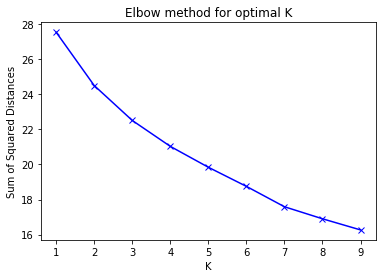

In [25]:
# Elbow method to find optimal K

x = ubahn_grouped.drop('Station', 1)

elbow = []
K_elbow = range(1,10)

for k in K_elbow:
    km = KMeans(n_clusters=k, random_state=5)
    km = km.fit(x)
    elbow.append(km.inertia_)

plt.plot(K_elbow, elbow, 'bx-')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow method for optimal K')

plt.show()

2 3 4 5 6 7 8 9 10 11 12 13 14 

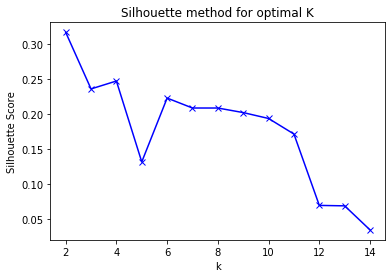

In [26]:
# Silhouette method to find optimal k

x = ubahn_grouped.drop('Station', 1)

sil = []
K_sil = range(2,15)

for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(x)
    labels = kmeans.labels_
    sil.append(silhouette_score(x, labels, metric = 'euclidean'))
    
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette method for optimal K')

plt.show()

#### Run k-means to cluster the stations into 4 clusters:

In [27]:
# Set number of clusters
kclusters = 4

ubahn_grouped_clustering = ubahn_grouped.drop('Station', 1)

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ubahn_grouped_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

#### Let's create a new dataframe that include the cluster as well as the top 10 venues for each station

In [28]:
# Add clustering labels
ubahn_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_.astype(int))

# Merge ubahn_grouped with df_ubahn to add latitude/longitude for each neighborhood
ubahn_merged = df_ubahn
ubahn_merged = ubahn_merged.join(ubahn_venues_sorted.set_index('Station'), on='Station')

ubahn_merged = ubahn_merged.dropna().reset_index(drop=True)

ubahn_merged.head()

,Station,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adenauerplatz,52.499722,13.307222,1.0,Italian Restaurant,Vietnamese Restaurant,Steakhouse,Asian Restaurant,German Restaurant,Chinese Restaurant,American Restaurant,Sushi Restaurant,Mediterranean Restaurant,Greek Restaurant
1,Afrikanische Straße,52.560556,13.334167,1.0,Argentinian Restaurant,Indian Restaurant,Seafood Restaurant,Yemeni Restaurant,Franconian Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant
2,Alexanderplatz,52.521389,13.413333,1.0,Vietnamese Restaurant,Italian Restaurant,German Restaurant,Burger Joint,Sushi Restaurant,Sandwich Place,Asian Restaurant,Indian Restaurant,Thai Restaurant,Burrito Place
3,Altstadt Spandau,52.539167,13.205556,1.0,Italian Restaurant,German Restaurant,Seafood Restaurant,Pizza Place,Doner Restaurant,Thai Restaurant,Turkish Restaurant,Vietnamese Restaurant,Sushi Restaurant,Dumpling Restaurant
4,Alt-Mariendorf,52.439722,13.387500,1.0,Steakhouse,Pizza Place,Italian Restaurant,Chinese Restaurant,Greek Restaurant,German Restaurant,Yemeni Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant


#### Finally, let's visualize the resulting clusters

In [29]:
# Create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        ubahn_merged['Latitude'],
        ubahn_merged['Longitude'],
        ubahn_merged['Station'],
        ubahn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' (Cluster ' + str(cluster) + ')', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)

# Show map
map_clusters

In [30]:
# Save map in html file
map_clusters.save('map_clusters.html')

#### Let's examine the clusters:

In [31]:
# Extract the 1st and 2nd Most Common Venue
first_second_indices = [4,5]
first_second = [list(ubahn_merged.columns.values)[i] for i in first_second_indices]

#### Cluster 1

In [32]:
cluster1 = ubahn_merged.loc[ubahn_merged['Cluster Labels'] == 0,
                            ubahn_merged.columns[[0] + list(range(4, ubahn_merged.shape[1]))]]
cluster1.head()

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Birkenstraße,Doner Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Taverna,French Restaurant,German Restaurant,Austrian Restaurant,Turkish Restaurant,Burger Joint,Egyptian Restaurant
24,Cottbusser Platz,Doner Restaurant,Italian Restaurant,Snack Place,Yemeni Restaurant,Franconian Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant
29,Elsterwerdaer Platz,Doner Restaurant,Italian Restaurant,Snack Place,Asian Restaurant,French Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant
34,Franz-Neumann-Platz,Doner Restaurant,Pizza Place,French Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fish & Chips Shop
48,Haselhorst,Doner Restaurant,BBQ Joint,Fried Chicken Joint,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fish & Chips Shop


In [33]:
for col in first_second:
    print(cluster1[col].value_counts(ascending = False))
    print("-----------------------------------------")

Doner Restaurant        16
French Restaurant        1
Snack Place              1
Italian Restaurant       1
Pizza Place              1
Pakistani Restaurant     1
Name: 1st Most Common Venue, dtype: int64
-----------------------------------------
Italian Restaurant               6
Asian Restaurant                 3
Pizza Place                      2
Vietnamese Restaurant            2
Turkish Restaurant               1
Eastern European Restaurant      1
Snack Place                      1
Sushi Restaurant                 1
Vegetarian / Vegan Restaurant    1
BBQ Joint                        1
Doner Restaurant                 1
Argentinian Restaurant           1
Name: 2nd Most Common Venue, dtype: int64
-----------------------------------------


#### Cluster 2

In [34]:
cluster2 = ubahn_merged.loc[ubahn_merged['Cluster Labels'] == 1,
                            ubahn_merged.columns[[0] + list(range(4, ubahn_merged.shape[1]))]]
cluster2.head()

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adenauerplatz,Italian Restaurant,Vietnamese Restaurant,Steakhouse,Asian Restaurant,German Restaurant,Chinese Restaurant,American Restaurant,Sushi Restaurant,Mediterranean Restaurant,Greek Restaurant
1,Afrikanische Straße,Argentinian Restaurant,Indian Restaurant,Seafood Restaurant,Yemeni Restaurant,Franconian Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant
2,Alexanderplatz,Vietnamese Restaurant,Italian Restaurant,German Restaurant,Burger Joint,Sushi Restaurant,Sandwich Place,Asian Restaurant,Indian Restaurant,Thai Restaurant,Burrito Place
3,Altstadt Spandau,Italian Restaurant,German Restaurant,Seafood Restaurant,Pizza Place,Doner Restaurant,Thai Restaurant,Turkish Restaurant,Vietnamese Restaurant,Sushi Restaurant,Dumpling Restaurant
4,Alt-Mariendorf,Steakhouse,Pizza Place,Italian Restaurant,Chinese Restaurant,Greek Restaurant,German Restaurant,Yemeni Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant


In [35]:
for col in first_second:
    print(cluster2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Italian Restaurant               43
Vietnamese Restaurant            13
Asian Restaurant                  8
German Restaurant                 7
Turkish Restaurant                7
Sushi Restaurant                  5
Burger Joint                      4
Indian Restaurant                 3
Vegetarian / Vegan Restaurant     3
Pizza Place                       3
French Restaurant                 2
Steakhouse                        2
BBQ Joint                         2
Falafel Restaurant                2
Middle Eastern Restaurant         2
Sandwich Place                    2
Argentinian Restaurant            2
Doner Restaurant                  1
Seafood Restaurant                1
Japanese Restaurant               1
Greek Restaurant                  1
Eastern European Restaurant       1
Chinese Restaurant                1
Salad Place                       1
Persian Restaurant                1
Kebab Restaurant                  1
Name: 1st Most Common Venue, dtype: int64
----------------------

#### Cluster 3

In [36]:
cluster3 = ubahn_merged.loc[ubahn_merged['Cluster Labels'] == 2,
                            ubahn_merged.columns[[0] + list(range(4, ubahn_merged.shape[1]))]]
cluster3.head()

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Britz-Süd,Vegetarian / Vegan Restaurant,German Restaurant,Yemeni Restaurant,French Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant
23,Bundestag,German Restaurant,Burger Joint,BBQ Joint,Modern European Restaurant,Pizza Place,French Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant
25,Dahlem-Dorf,German Restaurant,Burger Joint,Asian Restaurant,Pizza Place,Fried Chicken Joint,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant
40,Gleisdreieck,German Restaurant,Yemeni Restaurant,French Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant
43,Grenzallee,Pizza Place,German Restaurant,Yemeni Restaurant,French Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant


In [37]:
for col in first_second:
    print(cluster3[col].value_counts(ascending = False))
    print("---------------------------------------------")

German Restaurant                9
Vegetarian / Vegan Restaurant    1
Eastern European Restaurant      1
Pizza Place                      1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
German Restaurant     3
Asian Restaurant      2
Italian Restaurant    2
Yemeni Restaurant     2
Burger Joint          2
Kebab Restaurant      1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


#### Cluster 4

In [38]:
cluster4 = ubahn_merged.loc[ubahn_merged['Cluster Labels'] == 3,
                            ubahn_merged.columns[[0] + list(range(4, ubahn_merged.shape[1]))]]
cluster4.head()

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Blaschkoallee,Italian Restaurant,Eastern European Restaurant,Pizza Place,Yemeni Restaurant,French Restaurant,Dumpling Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant
19,Breitenbachplatz,Italian Restaurant,Mexican Restaurant,Yemeni Restaurant,French Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant
36,Freie Universität,Italian Restaurant,Asian Restaurant,Yemeni Restaurant,French Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant
51,Heidelberger Platz,Italian Restaurant,Yemeni Restaurant,French Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant
83,Magdalenenstraße,Italian Restaurant,Doner Restaurant,Pizza Place,French Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant


In [39]:
for col in first_second:
    print(cluster4[col].value_counts(ascending = False))
    print("---------------------------------------------")

Italian Restaurant    13
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Doner Restaurant               3
Greek Restaurant               2
Indian Restaurant              2
German Restaurant              1
Eastern European Restaurant    1
Asian Restaurant               1
Mexican Restaurant             1
Middle Eastern Restaurant      1
Yemeni Restaurant              1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


## 5. Results <a name="results"></a>

By reaching the end of the analysis, where we got a sneak peak of a total of 173 U-Bahn stations and food venues surrounding them. I've scraped data from web resources like Wikipedia, python libraries like Geopy, and Foursquare Venue API, to set up a realistic data-analysis scenario. I could generalize the clusters as following:
* Cluster 1 — mostly Doner estaurants can be found at these stations; there are also Italian and Asian Restaurants nearby.
* Cluster 2 — Italian and Vietnamese Restaurants dominate around those stations and not suprisingly, German Restaurants also have a significant presence.
* Cluster 3 — surrounded mostly by German Restaurants.
* Cluster 4 — Italian Restaurants are again in the lead.

## 6. Conclusion <a name="conclusion"></a>

To conclude, I used K-means clustering which created 4 different clusters for Berlin U-Bahn stations having food venues surrouding around them. Whenever you have a chance to visit Berlin, I hope this map will give you an imagination of where to eat nearby the U-Bahn stations.

If time allows, I'd like to repeat the clustering for the S-Bahn stations, since it's also relevant in the context of food venues around public transportation.